# ※ 과제 안내
- 과제 배점: 각 문제당 10점, 총점 100점입니다. 부분 점수는 제공되지 않습니다.  

- 채점 기준:  
    - 출력 결과 일치: 제출한 코드가 제시된 출력 결과와 일치하는 경우에만 정답으로 인정됩니다.  
    - 코드의 다양성 인정: 출력 결과가 동일하다면 다양한 접근 방식을 존중하여 정답으로 인정합니다.

---
# 8주차 과제

In [4]:
import warnings
warnings.filterwarnings('ignore')

---
# Q1. Sunspots 데이터 시각화

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MultipleLocator

In [2]:
# -------------------------------
# [1] 데이터 준비
# sunspots.csv를 루트 폴더 아래 업로드합니다.
# 파일 다운로드 링크: https://www.notion.so/metacodem/8-1cc13fa025c08037b713f2d64021b06b?pvs=4
# -------------------------------
def load_and_prepare_data():
    '''코드를 작성하시오'''

    df = pd.read_csv('./sunspots.csv') 
    return df

In [5]:
# -------------------------------
# [2] 전처리 함수
# -------------------------------
def add_features(df, ma_window=10):
    #이동 평균 컬럼, 전년도 대비 백분윤 변화율, IQR, 10년 단위로 그룹화하기 위한 'Decade' 컬럼 추가
    #decade_avg는 10년 단위의 평균 흑점 개수 입니다.

    df[f"{ma_window}Y_MA"] = df["SUNACTIVITY"].rolling(window=ma_window, min_periods=1).mean()
    df["pct_change"] = df["SUNACTIVITY"].pct_change() * 100
    Q1, Q3 = df["SUNACTIVITY"].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower_bound, upper_bound = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    df["is_outlier"] = (df["SUNACTIVITY"] < lower_bound) | (df["SUNACTIVITY"] > upper_bound)
    df["Decade"] = (df["YEAR"] // 10) * 10
    decade_avg = df.groupby("Decade")["SUNACTIVITY"].mean()

    return df, decade_avg

In [6]:
# -------------------------------
# [3] 시각화 함수 (개별)
# -------------------------------
def plot_moving_average(df, ma_window=10, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(df.index, df["SUNACTIVITY"], label="Original", color="blue")
    ax.plot(df.index, df[f"{ma_window}Y_MA"], label=f"{ma_window}-Year Moving Average", color="orange", linestyle="--")
    ax.set_title("Sunspot Activity with Moving Average")
    ax.set_xlabel("Year")
    ax.set_ylabel("Sunspot Count")
    ax.legend()
    ax.grid(True)
    ax.yaxis.set_major_locator(MultipleLocator(25))



def plot_outliers(df, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(df.index, df["SUNACTIVITY"], color="gray", label="All Data")
    outliers = df[df["is_outlier"]]
    ax.scatter(outliers.index, outliers["SUNACTIVITY"], color="red", label="Outliers")
    ax.set_title("Outlier Detection (IQR)")
    ax.set_xlabel("Year")
    ax.set_ylabel("Activity")
    ax.legend()
    ax.grid(True)
    ax.yaxis.set_major_locator(MultipleLocator(25))




def plot_percentage_change(df, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(df.index, df["pct_change"], label="Year-over-Year % Change", color="purple",marker = 'o')
    ax.set_title("Annual % Change")
    ax.set_xlabel("Year")
    ax.set_ylabel("% Change")
    ax.legend()
    ax.grid(True)




def plot_decadal_average(decade_avg, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 4))

    x = decade_avg.index.astype(int)

    ax.bar(
        x=x,
        height=decade_avg.values,
        width=9,
        align='center',  # 막대를 decade 시작점에 맞춤
        color='skyblue',
        alpha=1
    )

    ax.set_title("Decadal Average")
    ax.set_xlabel("Decade")
    ax.set_ylabel("Average")

    ax.set_xticks(x)
    ax.set_xticklabels(x, rotation=45)
    ax.set_xlim(left=1700, right=x[-1] + 10)  # x축 시작을 1700으로 고정
    ax.grid(True)






In [7]:
# -------------------------------
# [4] 전체 시각화 (통합)
# -------------------------------
def plot_all_sunspot_analysis(df, decade_avg, ma_window=10):

    fig, axs = plt.subplots(3, 2, figsize=(16, 10))
    fig.suptitle("Sunspot Activity Analysis", fontsize=16)


    plot_moving_average(df, ma_window, axs[0, 0])
    plot_outliers(df, axs[0, 1])
    plot_percentage_change(df, axs[1, 0])
    plot_decadal_average(decade_avg, axs[1, 1])

    axs[2, 0].axis('off')
    axs[2, 1].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

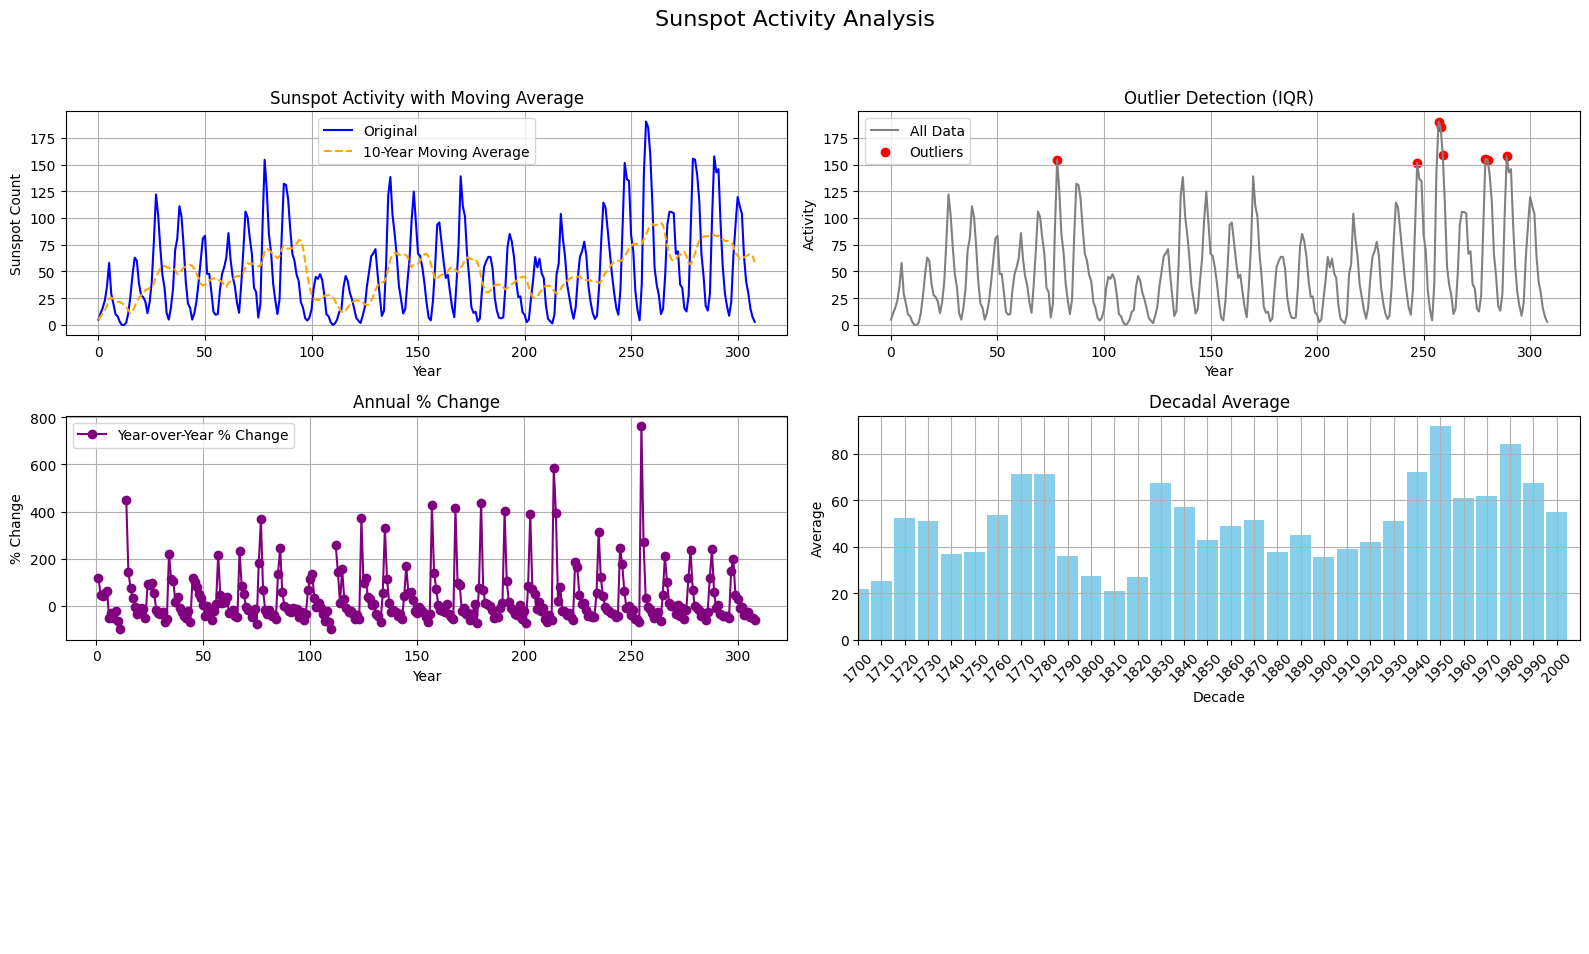

In [8]:
# -------------------------------
# [5] 실행하였을 때 결과물이 같아야 합니다.
# -------------------------------
df = load_and_prepare_data()
df, decade_avg = add_features(df)
plot_all_sunspot_analysis(df, decade_avg, ma_window=10)

---
# Q2. Sunspots 데이터 통계 요약 & Streamlit 배포

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis, gaussian_kde

In [9]:
# --------------------------------------------
# 1) 기본 통계 요약 및 분포 분석
# --------------------------------------------
# 데이터 불러오기 & 전처리
sun = load_and_prepare_data()
# 기본 통계 요약 출력
print("기본 통계 요약:")
print(sun.describe())

# 왜도와 첨도 계산
data_skew = skew(sun["SUNACTIVITY"])
data_kurtosis = kurtosis(sun["SUNACTIVITY"])


print("\n데이터 왜도 (Skewness):", data_skew)
print("데이터 첨도 (Kurtosis):", data_kurtosis)

기본 통계 요약:
              YEAR  SUNACTIVITY
count   309.000000   309.000000
mean   1854.000000    49.752104
std      89.344838    40.452595
min    1700.000000     0.000000
25%    1777.000000    16.000000
50%    1854.000000    40.000000
75%    1931.000000    69.800000
max    2008.000000   190.200000

데이터 왜도 (Skewness): 0.9857343925899044
데이터 첨도 (Kurtosis): 0.41102334998273227


In [11]:
# --------------------------------------------
# 2) 결측치 및 이상치 확인
# --------------------------------------------

# 결측치 개수 확인
print("\n결측치 개수:")
print(sun.isnull().sum())

# IQR 방법을 사용한 이상치 탐지
Q1 = sun["SUNACTIVITY"].quantile(0.25)
Q3 = sun["SUNACTIVITY"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"\n이상치 탐지를 위한 경계값: 하한 {lower_bound}, 상한 {upper_bound}")

# 이상치 데이터 확인
outliers = sun[(sun["SUNACTIVITY"] < lower_bound) | (sun["SUNACTIVITY"] > upper_bound)]

print("\n탐지된 이상치:")
print(outliers)


결측치 개수:
YEAR           0
SUNACTIVITY    0
dtype: int64

이상치 탐지를 위한 경계값: 하한 -64.69999999999999, 상한 150.5

탐지된 이상치:
       YEAR  SUNACTIVITY
78   1778.0        154.4
247  1947.0        151.6
257  1957.0        190.2
258  1958.0        184.8
259  1959.0        159.0
279  1979.0        155.4
280  1980.0        154.6
289  1989.0        157.6


In [12]:
# --------------------------------------------
# 3) 심화 시각화: 다중 서브플롯 구성
# --------------------------------------------
def plot_advanced_sunspot_visualizations(df, sunactivity_col='SUNACTIVITY'):
    """
    태양흑점 데이터의 심화 시각화를 위한 2x2 서브플롯 함수.

    Parameters:
        df: 시계열 데이터프레임 (datetime index 포함)
        sunactivity_col (str): 분석 대상 컬럼명 (기본: 'SUNACTIVITY')
    """
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle("Sunspots Data Advanced Visualization", fontsize=16)
    # (a) 전체 시계열 라인 차트
    # 전체 시간대(1700년~2000년+) 동안의 흑점 수 추세 시각화

    axs[0, 0].plot(df["YEAR"], df[sunactivity_col], color='blue', linewidth=1)
    axs[0, 0].set_title("Sunspot Activity Over Time")
    axs[0, 0].set_xlabel("Year")
    axs[0, 0].set_ylabel(sunactivity_col)
    axs[0, 0].grid(True)


    # (b) 분포: 히스토그램 + 커널 밀도

    data = df[sunactivity_col].dropna()
    xs = np.linspace(data.min(), data.max(), 200)


    density = gaussian_kde(data)
    axs[0, 1].hist(data, bins=30, density=True, alpha=0.6, color='gray', label='Histogram')
    axs[0, 1].plot(xs, density(xs), color='red', linewidth=2, label='Density')
    axs[0, 1].set_title("Distribution of Sunspot Activity")
    axs[0, 1].set_xlabel(sunactivity_col)
    axs[0, 1].set_ylabel("Density")
    axs[0, 1].legend()
    axs[0, 1].grid(True)

    # (c) 상자 그림: 1900년~2000년

    df_20th = df[(df["YEAR"] >= 1900) & (df["YEAR"] <= 2000)]


    axs[1, 0].boxplot(df_20th[sunactivity_col], vert=False)
    axs[1, 0].set_title("Boxplot of Sunspot Activity (1900-2000)")
    axs[1, 0].set_xlabel(sunactivity_col)

    # (d) 산점도 + 회귀선

    years = df["YEAR"].values
    sun_activity = df[sunactivity_col].values


    axs[1, 1].scatter(years, sun_activity, s=10, alpha=0.5, label='Data Points')
    coef = np.polyfit(years, sun_activity, 1)
    trend = np.poly1d(coef)
    axs[1, 1].plot(years, trend(years), color='red', linewidth=2, label='Trend Line')
    axs[1, 1].set_title("Trend of Sunspot Activity")
    axs[1, 1].set_xlabel("Year")
    axs[1, 1].set_ylabel(sunactivity_col)
    axs[1, 1].legend()
    axs[1, 1].grid(True)

    # 레이아웃 정리
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

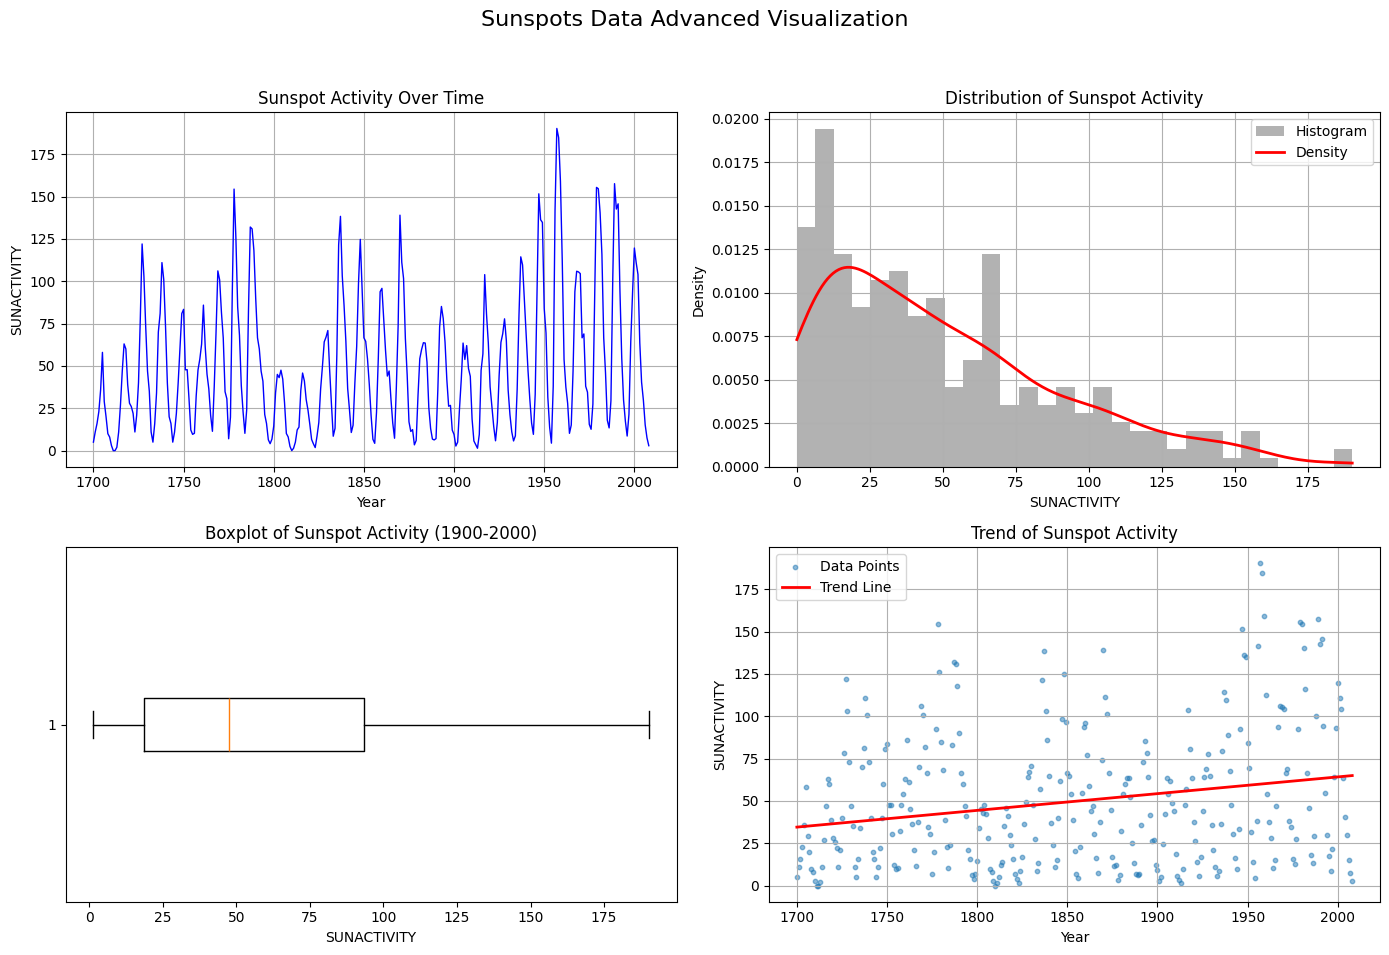

In [13]:
plot_advanced_sunspot_visualizations(df)

In [15]:
# --------------------------------------------
# 4) Streamlit 배포
# sunspots.csv 파일이 에디터 폴더의 data/아래에 있어야 합니다.
# --------------------------------------------
import streamlit as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

@st.cache_data
def load_data(file_path):
    df = pd.read_csv(file_path)
    if 'YEAR' in df.columns:
        # 소수점 제거 후 정수로 변환
        df['YEAR_INT'] = df['YEAR'].astype(int)
        df['DATE'] = pd.to_datetime(df['YEAR_INT'].astype(str), format='%Y')
        df.set_index('DATE', inplace=True)
    return df

def plot_advanced_sunspot_visualizations(df, sunactivity_col='SUNACTIVITY'):
    fig, axs = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle("Sunspots Data Advanced Visualization", fontsize=18)

    # (a) 전체 시계열 라인 차트
    axs[0, 0].plot(df['YEAR'], df[sunactivity_col], color='blue', linewidth=1)


    axs[0, 0].set_title("Sunspot Activity Over Time")
    axs[0, 0].set_xlabel("Year")
    axs[0, 0].set_ylabel("Sunspot Count")
    axs[0, 0].grid(True)

    # (b) 분포: 히스토그램 + 커널 밀도
    data = df[sunactivity_col].dropna().values
    if len(data) > 0:  # 데이터가 있는지 확인
        xs = np.linspace(data.min(), data.max(), 200)
        density = gaussian_kde(data)

        axs[0, 1].hist(data, bins=30, density=True, alpha=0.6, color='gray', label='Histogram')

        axs[0, 1].plot(xs, density(xs), color='red', linewidth=2, label='Density')
    axs[0, 1].set_title("Distribution of Sunspot Activity")
    axs[0, 1].set_xlabel("Sunspot Count")
    axs[0, 1].set_ylabel("Density")
    axs[0, 1].legend()
    axs[0, 1].grid(True)

    # (c) 상자 그림: 1900년~2000년
    try:
        df_20th = df.loc["1900":"2000"]
        if not df_20th.empty:
            axs[1, 0].boxplot(df_20th[sunactivity_col], vert=False)
            axs[1, 0].grid(True)

    except:
        # 해당 기간 데이터가 없을 경우 예외 처리
        pass
    axs[1, 0].set_title("Boxplot of Sunspot Activity (1900-2000)")
    axs[1, 0].set_xlabel("Sunspot Count")

    # (d) 산점도 + 회귀선
    years = df['YEAR'].values
    sun_activity = df[sunactivity_col].values

    # NaN 값 제거
    mask = ~np.isnan(sun_activity)
    years_clean = years[mask]
    sun_activity_clean = sun_activity[mask]

    if len(years_clean) > 1:  # 회귀선을 그리기 위해 최소 2개 이상의 데이터 필요
        axs[1, 1].scatter(years_clean, sun_activity_clean, s=10, alpha=0.5, label='Data Points')
        coef = np.polyfit(years_clean, sun_activity_clean, 1)
        trend = np.poly1d(coef)
        axs[1, 1].plot(years_clean, trend(years_clean), color='red', linewidth=2, label='Trend Line')
    axs[1, 1].set_title("Trend of Sunspot Activity")
    axs[1, 1].set_xlabel("Year")
    axs[1, 1].set_ylabel("Sunspot Count")
    axs[1, 1].legend()
    axs[1, 1].grid(True)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    return fig

# 메인 앱
st.title('🌞 태양흑점 데이터 분석 대시보드 🌞')
st.markdown("""
    이 대시보드는 태양흑점 데이터를 다양한 시각화 방법으로 보여줍니다.
    """)

try:
    # 데이터 로드
    df = load_data('data/sunspots.csv')

    # 필터링된 데이터 - 전체 데이터 사용
    filtered_df = df

    # 시각화
    if not filtered_df.empty:
        st.subheader('태양흑점 데이터 종합 시각화')
        fig = plot_advanced_sunspot_visualizations(filtered_df)
        st.pyplot(fig)
    else:
        st.warning("데이터가 없습니다.")

except Exception as e:
    st.error(f"오류가 발생했습니다: {e}")
    st.info("데이터 파일의 구조를 확인해주세요. 'data/sunspots.csv' 파일이 존재하고 'YEAR'와 'SUNACTIVITY' 컬럼이 있어야 합니다.")

2025-07-22 12:48:35.968 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-07-22 12:48:35.969 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-22 12:48:36.410 
  command:

    streamlit run C:\Users\lsrro\AppData\Roaming\Python\Python313\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-07-22 12:48:36.411 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-22 12:48:36.411 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-22 12:48:36.412 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-22 12:48:36.412 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-22 12:48:36.412 Thread

In [ ]:
'''streamlit 주소를 제출해주세요
주소는 이름+2 로 설정해주세요
'''
#ex https://HongGilDong2.streamlit.app

In [14]:
# streamlit 배포 결과
from IPython.display import Image, display
image_url = "https://i.imgur.com/Mq93Sgh.png"
display(Image(url=image_url, width=600))

# Q3. Streamlit 시각화 + 인터랙션 추가

In [ ]:
# --------------------------------------------
# Streamlit 시각화 + 인터랙션 추가
# sunspots.csv 파일이 에디터 폴더의 data/아래에 있어야 합니다.
# 연도범위, 히스토그램 구간 수, 추세선 차수, 산점도 점 크기, 산점도 투명도를 조절할 수 있는 기능을 추가합니다.
# --------------------------------------------
import streamlit as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

@st.cache_data
def load_data(file_path):
    df = pd.read_csv(file_path)
    if 'YEAR' in df.columns:
        # 소수점 제거 후 정수로 변환
        df['YEAR_INT'] = df['YEAR'].astype(int)
        df['DATE'] = pd.to_datetime(df['YEAR_INT'].astype(str), format='%Y')
        df.set_index('DATE', inplace=True)
    return df

def plot_advanced_sunspot_visualizations(df, sunactivity_col='SUNACTIVITY',
                                        hist_bins=30, trend_degree=1,
                                        point_size=10, point_alpha=0.5):
    fig, axs = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle("Sunspots Data Advanced Visualization", fontsize=18)

    # (a) 전체 시계열 라인 차트
    axs[0, 0].plot(df.index, df[sunactivity_col], color='blue')
    axs[0, 0].set_title("Sunspot Activity Over Time")
    axs[0, 0].set_xlabel("Year")
    axs[0, 0].set_ylabel("Sunspot Count")
    axs[0, 0].grid(True)

    # (b) 분포: 히스토그램 + 커널 밀도
    data = df[sunactivity_col].dropna().values
    if len(data) > 0:  # 데이터가 있는지 확인
        xs = np.linspace(data.min(), data.max(), 200)
        density = gaussian_kde(data)

        '''코드를 작성하시오'''

        axs[0, 1].plot(xs, density(xs), color='red', linewidth=2, label='Density')
    axs[0, 1].set_title("Distribution of Sunspot Activity")
    axs[0, 1].set_xlabel("Sunspot Count")
    axs[0, 1].set_ylabel("Density")
    axs[0, 1].legend()
    axs[0, 1].grid(True)

    # (c) 상자 그림: 1900년~2000년
    try:
        df_20th = df.loc["1900":"2000"]
        if not df_20th.empty:
            '''코드를 작성하시오'''

    except:
        # 해당 기간 데이터가 없을 경우 예외 처리
        pass
    axs[1, 0].set_title("Boxplot of Sunspot Activity (1900-2000)")
    axs[1, 0].set_xlabel("Sunspot Count")

    # (d) 산점도 + 회귀선
    years = df['YEAR'].values
    sun_activity = df[sunactivity_col].values

    # NaN 값 제거
    mask = ~np.isnan(sun_activity)
    years_clean = years[mask]
    sun_activity_clean = sun_activity[mask]

    if len(years_clean) > 1:  # 회귀선을 그리기 위해 최소 2개 이상의 데이터 필요
        axs[1, 1].scatter(years_clean, sun_activity_clean, s=point_size, alpha=point_alpha, label='Data Points')
        coef = np.polyfit(years_clean, sun_activity_clean, trend_degree)
        trend = np.poly1d(coef)

        # 추세선을 그리기 위한 x 값 생성
        x_trend = np.linspace(years_clean.min(), years_clean.max(), 100)
        axs[1, 1].plot(x_trend, trend(x_trend), color='red', linewidth=2, label='Trend Line')
    axs[1, 1].set_title("Trend of Sunspot Activity")
    axs[1, 1].set_xlabel("Year")
    axs[1, 1].set_ylabel("Sunspot Count")
    axs[1, 1].legend()
    axs[1, 1].grid(True)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    return fig

# 메인 앱
st.title('🌞 태양흑점 데이터 분석 대시보드 🌞')
st.markdown("""
    이 대시보드는 태양흑점 데이터를 다양한 시각화 방법으로 보여줍니다.
    """)

try:
    # 데이터 로드
    df = load_data('data/sunspots.csv')

    # 사이드바에 파라미터 조절 슬라이더 추가
    '''코드를 작성하시오'''

    # 연도 범위 선택
    '''코드를 작성하시오'''


    # 히스토그램 빈(bin) 수 조절
    hist_bins = st.sidebar.slider(
        '히스토그램 구간 수',
        min_value=5,
        max_value=100,
        value=30
    )

    # 추세선 차수 조절
    trend_degree = st.sidebar.slider(
        '추세선 차수',
        min_value=1,
        max_value=5,
        value=1
    )

    # 산점도 점 크기 조절
    '''코드를 작성하시오'''



    # 산점도 투명도 조절
    '''코드를 작성하시오'''



    # 필터링된 데이터
    filtered_df = df[(df['YEAR'] >= year_range[0]) & (df['YEAR'] <= year_range[1])]

    # 시각화
    if not filtered_df.empty:
        st.subheader('태양흑점 데이터 종합 시각화')
        fig = plot_advanced_sunspot_visualizations(
            filtered_df,
            hist_bins=hist_bins,
            trend_degree=trend_degree,
            point_size=point_size,
            point_alpha=point_alpha
        )
        st.pyplot(fig)
    else:
        st.warning("선택한 기간에 데이터가 없습니다.")

except Exception as e:
    st.error(f"오류가 발생했습니다: {e}")
    st.info("데이터 파일의 구조를 확인해주세요. 'data/sunspots.csv' 파일이 존재하고 'YEAR'와 'SUNACTIVITY' 컬럼이 있어야 합니다.")

In [ ]:
'''streamlit 주소를 제출해주세요
주소는 이름+3 로 설정해주세요
'''
#ex https://HongGilDong3.streamlit.app

In [ ]:
# streamlit 배포 결과
from IPython.display import Image, display
image_url = "https://i.imgur.com/lVpB5AP.png"
display(Image(url=image_url, width=600))

---
# Q4. Prophet 모델 학습

In [ ]:
'''
[1] 데이터 준비 및 전처리
data는 위에서 제공해드린 코드로 sunspots를 사용하고자 합니다.
현재 모델 학습을 위해서 다음과 같은 전처리를 하고자 합니다.
# - 'date'와 'SUNACTIVITY' 컬럼만 추출, 데이터 변환
# - 1900년 이후(1900-01-01 ~ 2008-01-01) datetime 데이터로 제한, %Y-%m-%d의 형태

이 두가지를 거쳐서 학습을 하고자 합니다.

Q1~Q2로부터 나온 df를 그대로 사용합니다.
'''

processed_df = '''코드를 작성하시오'''

print("데이터 미리보기:")
print(processed_df.head())

데이터 미리보기:
            ds     y
200 1900-01-01   9.5
201 1901-01-01   2.7
202 1902-01-01   5.0
203 1903-01-01  24.4
204 1904-01-01  42.0


In [ ]:
# [2] 모델 학습
# - 기본 yearly_seasonality를 비활성화하고, changepoint_prior_scale 등 파라미터 튜닝
# - Sunspot 데이터의 주기성(약 11년)을 반영하는 커스텀 시즌얼리티 추가
from prophet import Prophet

model = Prophet(
    yearly_seasonality=False,  # 기본 연간 시즌얼리티 비활성화
    changepoint_prior_scale=0.05,
    seasonality_mode='additive'
)
# 약 11년 주기의 태양 흑점 사이클을 커스텀 시즌얼리티로 추가 (fourier_order는 데이터에 따라 조정)
model.add_seasonality(name='sunspot_cycle', period=11, fourier_order=5)
# 모델 학습
model.fit(processed_df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqrdqqc7_/nb0lgk04.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqrdqqc7_/e4x2fys9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99381', 'data', 'file=/tmp/tmpqrdqqc7_/nb0lgk04.json', 'init=/tmp/tmpqrdqqc7_/e4x2fys9.json', 'output', 'file=/tmp/tmpqrdqqc7_/prophet_model3b9ctzof/prophet_model-20250404144857.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:48:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:48:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# [3] 예측
# - 50년 뒤까지 예측하기 위한 future DataFrame 생성 (연 단위)
future = model.make_future_dataframe(periods=50, freq='Y')
forecast = model.predict(future)
print("\nForecast 상위 5행:")
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())


Forecast 상위 5행:
          ds       yhat  yhat_lower  yhat_upper
0 1900-01-01  41.194331  -17.392842   98.572105
1 1901-01-01  48.750280   -9.323614  105.432477
2 1902-01-01  55.225632   -2.975891  116.573712
3 1903-01-01  60.719475    2.632876  119.650610
4 1904-01-01  53.813352   -5.136381  109.200574


INFO:prophet:Making 4 forecasts with cutoffs between 1983-01-07 00:00:00 and 1998-01-03 00:00:00



교차 검증 시작...


  0%|          | 0/4 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpqrdqqc7_/9z9z5n1s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqrdqqc7_/_ogazhc5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30507', 'data', 'file=/tmp/tmpqrdqqc7_/9z9z5n1s.json', 'init=/tmp/tmpqrdqqc7_/_ogazhc5.json', 'output', 'file=/tmp/tmpqrdqqc7_/prophet_model89d20ggg/prophet_model-20250404144911.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
14:49:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:49:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqrdqqc7_/fqj8kuoq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqrdqqc7_/skc5sgv9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local


Performance Metrics 상위 5행:
   horizon          mse       rmse        mae      mape     mdape     smape  \
0 363 days  3298.983693  57.436780  51.026713  1.021075  0.793220  0.624521   
1 725 days  4622.836058  67.991441  60.415939  1.986260  1.437259  0.801225   
2 726 days  4056.028574  63.686958  55.953991  1.967058  1.398854  0.770390   
3 727 days  4556.196066  67.499600  59.136907  2.576717  2.618172  0.850986   
4 728 days  4828.079676  69.484384  65.669917  2.626778  2.618172  0.911832   

   coverage  
0      0.50  
1      0.25  
2      0.50  
3      0.50  
4      0.50  


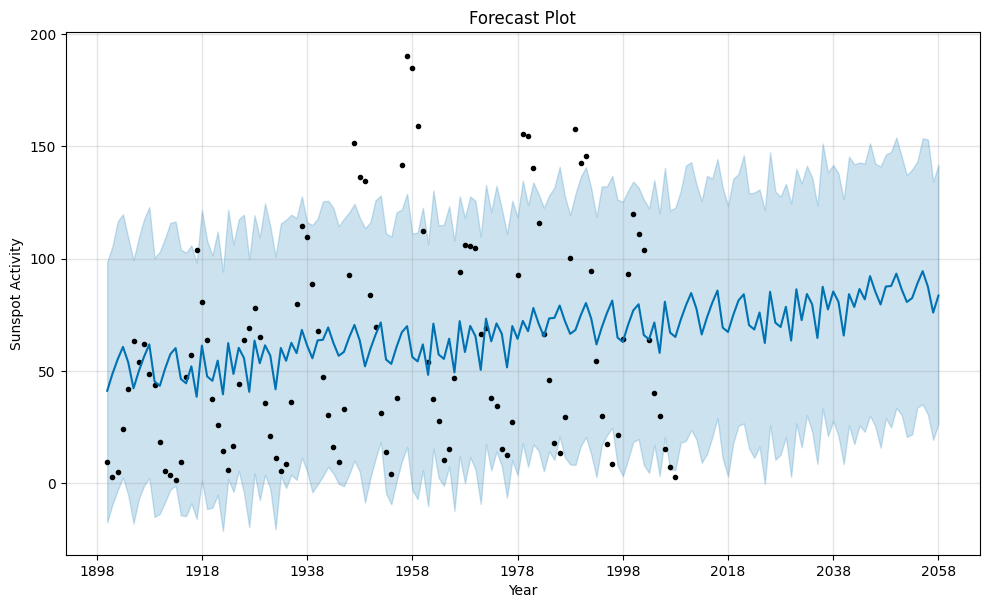

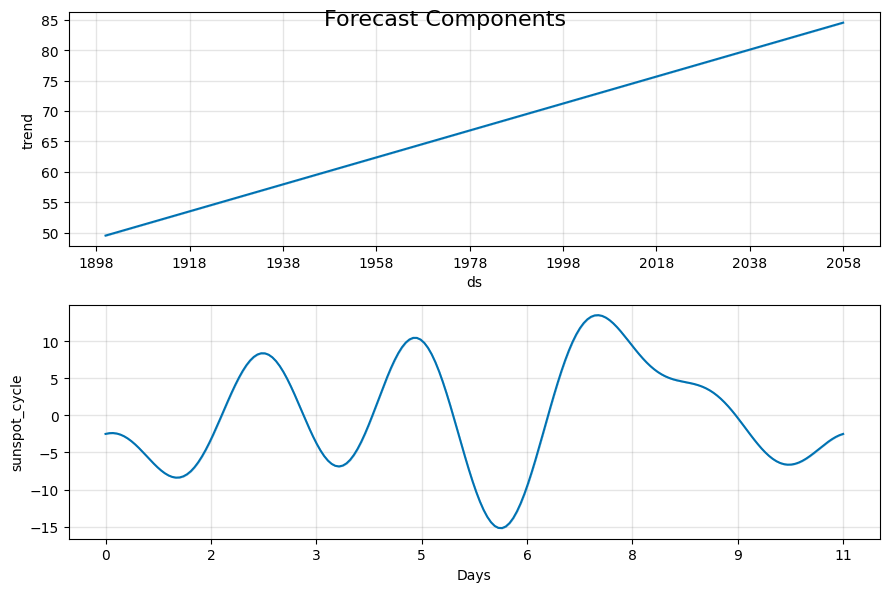

In [ ]:
# [4] 모델 진단: 교차 검증 및 성능 평가 (선택 사항)
# Prophet의 교차 검증 기능을 사용하여 예측 성능을 평가합니다.
# 데이터 기간이 1900~2008년이므로, 초기 학습 기간은 80년, horizon은 10년, period는 5년으로 설정합니다.
from prophet.diagnostics import cross_validation, performance_metrics

print("\n교차 검증 시작...")
cv_results = cross_validation(model, initial='29200 days', period='1825 days', horizon='3650 days')
perf_metrics = performance_metrics(cv_results)
print("\nPerformance Metrics 상위 5행:")
print(perf_metrics.head())

# [5] 예측 결과 시각화 (예측 구성요소 플롯)
fig1 = model.plot(forecast)
plt.title("Forecast Plot")
plt.xlabel("Year")
plt.ylabel("Sunspot Activity")
plt.show()

fig2 = model.plot_components(forecast)
plt.suptitle("Forecast Components", fontsize=16)
plt.show()

---
# Q5. Prophet 예측 결과 시각화 & Stremalit 배포

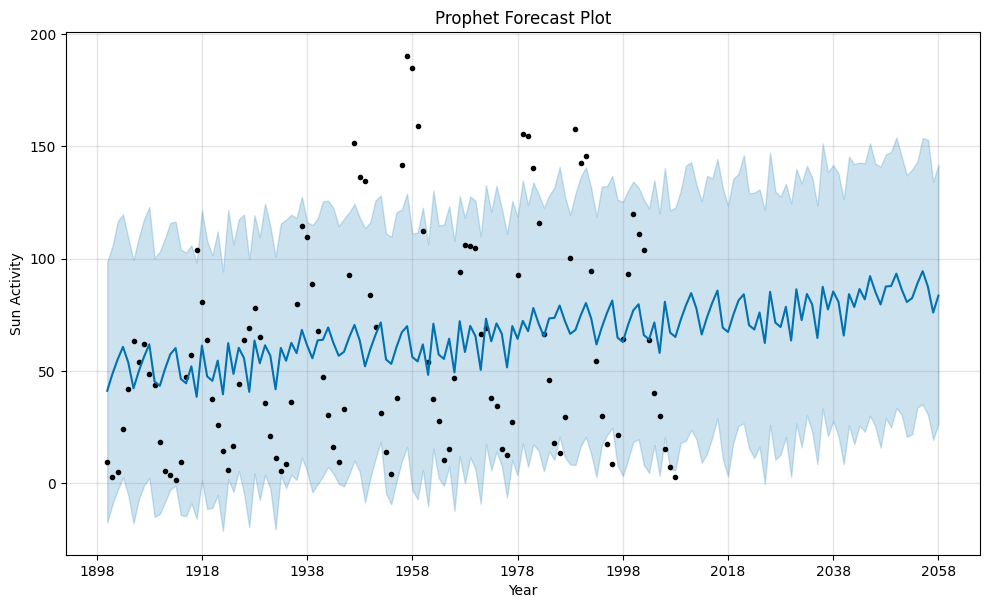

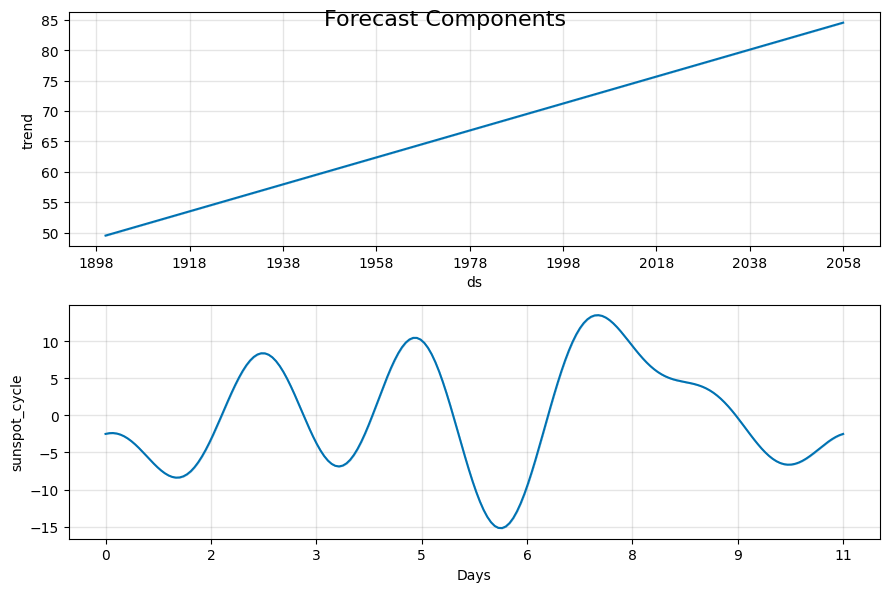

In [ ]:
# --------------------------------------------------
# [1] Prophet 내장 시각화
# --------------------------------------------------
# TODO 1: model.plot()과 model.plot_components()를 사용하여 Prophet의 기본 시각화를 출력하세요.

'''코드를 작성하시오'''
# Prophet 모델이 제공하는 기본 플롯 함수로 예측 결과와 구성요소를 시각화합니다.


fig2 = model.plot_components(forecast)
plt.suptitle("Forecast Components", fontsize=16)
plt.show()



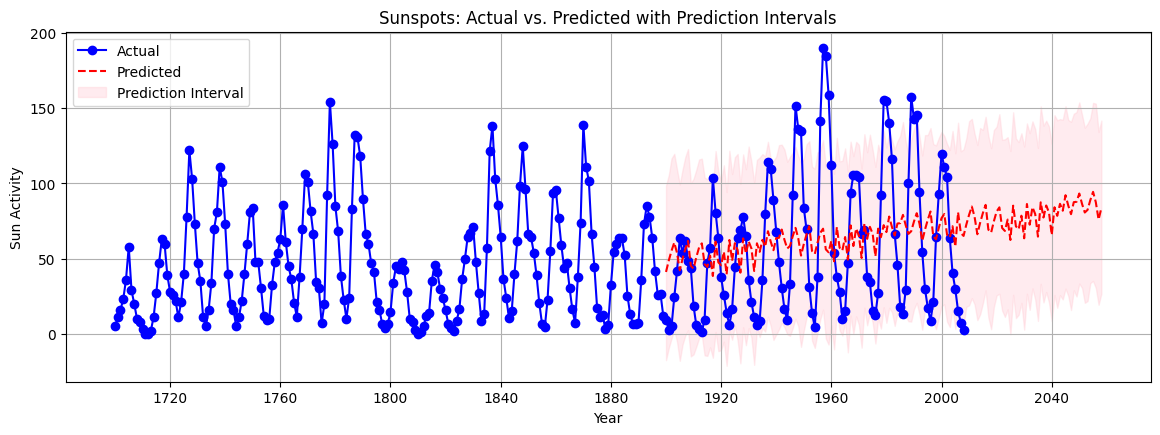

In [ ]:
# --------------------------------------------------
# [2] 실제 값과 예측 값 비교: 커스텀 시각화 (라인 차트 + 신뢰구간)
# --------------------------------------------------
# TODO 2: 실제값, 예측값, 신뢰구간을 하나의 plot에 함께 시각화하세요.

plt.figure(figsize=(14, 10))
plt.subplot(2, 1, 1)

'''코드를 작성하시오'''
# 힌트:
# plt.plot(df.index, df["SUNACTIVITY"], ...)
# plt.plot(forecast["ds"], forecast["yhat"], ...)
# plt.fill_between(forecast["ds"], forecast["yhat_lower"], forecast["yhat_upper"], ...)


plt.title("Sunspots: Actual vs. Predicted with Prediction Intervals")
plt.xlabel("Year")
plt.ylabel("Sun Activity")
plt.legend()
plt.grid(True)

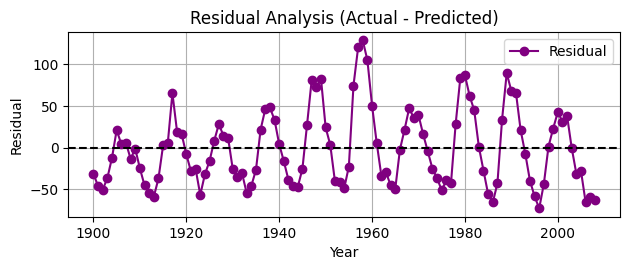

In [ ]:
# --------------------------------------------------
# [3] 잔차(Residual) 분석: 예측값과 실제값의 차이 시각화
# --------------------------------------------------
# TODO 3: df와 forecast를 날짜 기준으로 병합하고, 잔차를 계산한 뒤 시각화하세요.

# 3-1. df의 인덱스를 초기화하고, 날짜 컬럼명을 Prophet 형식(ds)으로 변경
'''코드를 작성하시오'''


# 3-2. forecast와 병합 (inner join) 후 residual 컬럼 생성
'''코드를 작성하시오'''


# 3-3. 잔차 시각화
plt.subplot(2, 1, 2)

'''코드를 작성하시오'''
# 힌트:
# plt.plot(merged["ds"], merged["residual"], ...)
# plt.axhline(0, ...)  # 기준선

plt.title("Residual Analysis (Actual - Predicted)")
plt.xlabel("Year")
plt.ylabel("Residual")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# 원본 데이터 로드

import statsmodels.api as sm
df = sm.datasets.sunspots.load_pandas().data
df["YEAR"] = df["YEAR"].astype(int)
df["date"] = pd.to_datetime(df["YEAR"], format="%Y")
df = df.set_index("date").sort_index()

# Prophet용 전처리
# 1. 인덱스를 다시 컬럼으로 변환(reset_index)
# 2. Prophet은 입력 컬럼명으로 'ds'(날짜)와 'y'(타겟값)를 요구하므로 컬럼명 변경
''' 코드 작성 '''
processed_df =



# 1900-01-01부터 2008-01-01까지의 데이터만 필터링
# Prophet 모델 학습에 사용할 기간을 제한함
''' 코드 작성 '''
processed_df =


# 전처리된 데이터프레임을 CSV 파일(경로: ./sunspots_for_prophet.csv)로 저장
# index=False 옵션은 데이터프레임의 인덱스를 CSV에 포함시키지 않음
# 저장한 파일도 같이 제출해주세요.
''' 코드 작성 '''


print("✅ prophet용 데이터 저장 완료!")


✅ prophet용 데이터 저장 완료!


In [ ]:
# --------------------------------------------------
# [4] 시각화한 내용을 Steamlit에 배포하세요.
# 위에서 생성한 sunspots_for_prophet.csv를 다운로드 받아, 루트/data 아래에 넣어주세요.
# --------------------------------------------------
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet

# 페이지 설정
st.set_page_config(page_title="🌞 Sunspot Forecast", layout="wide")
st.title("🌞 Prophet Forecast with Preprocessed Sunspot Data")

# ----------------------------------
# [1] 데이터 불러오기
# ----------------------------------
# TODO: 'sunspots_for_prophet.csv' 파일을 불러오고, 'ds' 컬럼을 datetime 형식으로 변환하세요.
'''코드를 작성하시오'''


st.subheader("📄 데이터 미리보기")
'''코드를 작성하시오'''

# ----------------------------------
# [2] Prophet 모델 정의 및 학습
# ----------------------------------
# TODO: Prophet 모델을 생성하고, 11년 주기 커스텀 seasonality를 추가한 후 학습하세요.
'''코드를 작성하시오'''

# ----------------------------------
# [3] 예측 수행
# ----------------------------------
# TODO: 30년간 연 단위 예측을 수행하고, 결과를 forecast에 저장하세요.
'''코드를 작성하시오'''

# ----------------------------------
# [4] 기본 시각화
# ----------------------------------
st.subheader("📈 Prophet Forecast Plot")
# TODO: model.plot()을 사용하여 예측 결과를 시각화하세요.
'''코드를 작성하시오'''

st.subheader("📊 Forecast Components")
# TODO: model.plot_components()를 사용하여 구성요소를 시각화하세요.
'''코드를 작성하시오'''

# ----------------------------------
# [5] 커스텀 시각화: 실제값 vs 예측값 + 신뢰구간
# ----------------------------------
st.subheader("📉 Custom Plot: Actual vs Predicted with Prediction Intervals")

# TODO: 실제값, 예측값, 신뢰구간을 하나의 plot에 시각화하세요.
fig3, ax = plt.subplots(figsize=(14, 6))

'''코드를 작성하시오'''
# 힌트:
# ax.plot(df["ds"], df["y"], ...)
# ax.plot(forecast["ds"], forecast["yhat"], ...)
# ax.fill_between(forecast["ds"], forecast["yhat_lower"], forecast["yhat_upper"], ...)

st.pyplot(fig3)

# ----------------------------------
# [6] 잔차 분석 시각화
# ----------------------------------
st.subheader("📉 Residual Analysis (예측 오차 분석)")

# TODO: df와 forecast를 'ds' 기준으로 병합하여 residual 컬럼을 생성하세요.
'''코드를 작성하시오'''

# TODO: residual 시계열을 시각화하세요.
fig4, ax2 = plt.subplots(figsize=(14, 4))

'''코드를 작성하시오'''
# 힌트:
# ax2.plot(merged["ds"], merged["residual"], ...)
# ax2.axhline(0, ...)

st.pyplot(fig4)

# ----------------------------------
# [7] 잔차 통계 요약 출력
# ----------------------------------
st.subheader("📌 Residual Summary Statistics")
# TODO: merged["residual"].describe()를 출력하세요.
'''코드를 작성하시오'''


In [ ]:
'''streamlit 주소를 제출해주세요
주소는 이름+5 로 설정해주세요
'''
#ex https://HongGilDong5.streamlit.app

In [ ]:
# streamlit 배포 결과
from IPython.display import Image, display
image_url = "https://i.imgur.com/b3e0XU7.png"
display(Image(url=image_url, width=600))

# Q6. 머신러닝 실습 1

In [ ]:
'''
# 채무불이행 데이터로 예측 모델을 학습시키고, 베스트 모델과 accuracy를 뽑아냅니다.
# test.csv, train.csv를 루트 폴더 아래 업로드합니다.
# 파일 다운로드 링크: https://www.notion.so/metacodem/8-1cc13fa025c08037b713f2d64021b06b

'''
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import warnings
warnings.filterwarnings('ignore')

# 1. 데이터 로드
'''코드를 작성하시오'''



In [ ]:
# 2. 데이터 탐색 및 기본 분석
'''코드를 작성하시오'''


Train 데이터 크기: (10000, 18)
Test 데이터 크기: (2062, 17)


In [ ]:
# 3. 데이터 전처리 함수 정의
def preprocess_data(df, is_train=True):
    # 복사본 생성
    df_copy = df.copy()

    # 3.1 범주형 변수 처리를 위한 사전 정의 (순서가 있는 변수 처리)
    tenure_order = {
        '1년 미만': 0,
        '1년': 1,
        '2년': 2,
        '3년': 3,
        '4년': 4,
        '5년': 5,
        '6년': 6,
        '7년': 7,
        '8년': 8,
        '9년': 9,
        '10년 이상': 10
    }

    loan_term_order = {
        '단기 상환': 0,
        '장기 상환': 1
    }

    # 3.2 특성 엔지니어링

    # 3.2.1 근속 연수 숫자로 변환
    df_copy['근속_연수_숫자'] = df_copy['현재 직장 근속 연수'].map(tenure_order)

    # 3.2.2 대출 상환 기간 숫자로 변환
    df_copy['상환_기간_숫자'] = df_copy['대출 상환 기간'].map(loan_term_order)

    # 3.2.3 소득 대비 부채 비율 계산
    df_copy['소득_대비_부채_비율'] = df_copy['현재 대출 잔액'] / df_copy['연간 소득']

    # 3.2.4 월 상환액 대비 소득 비율
    df_copy['월_상환액_대비_소득_비율'] = (df_copy['월 상환 부채액'] * 12) / df_copy['연간 소득']

    # 3.2.5 대출 잔액 대비 미상환 신용액 비율
    df_copy['대출_대비_미상환_비율'] = df_copy['현재 미상환 신용액'] / (df_copy['현재 대출 잔액'] + 1)  # 0으로 나누기 방지

    # 3.2.6 신용 위험 지수 (가중치 합)
    df_copy['신용_위험_지수'] = (
        df_copy['신용 문제 발생 횟수'] * 0.3 +
        df_copy['체납 세금 압류 횟수'] * 0.3 +
        df_copy['개인 파산 횟수'] * 0.4
    )

    # 3.2.7 신용 활동 지수
    df_copy['신용_활동_지수'] = df_copy['개설된 신용계좌 수'] / (df_copy['신용 거래 연수'] + 1)  # 0으로 나누기 방지

    # 3.2.8 마지막 연체 로그 변환 (0인 경우 처리)
    df_copy['연체_로그'] = np.log1p(df_copy['마지막 연체 이후 경과 개월 수'])

    # 3.2.9 신용 점수 구간화
    df_copy['신용_점수_구간'] = pd.cut(df_copy['신용 점수'],
                                bins=[0, 580, 670, 740, 800, 850],
                                labels=['매우 낮음', '낮음', '보통', '좋음', '매우 좋음'])

    # 3.3 사용하지 않을 열 제거('UID', '현재 직장 근속 연수', '대출 상환 기간')
    ''' 코드 작성 '''


    df_copy = df_copy.drop(columns=columns_to_drop)

    # 3.4 타겟 변수 분리 (학습 데이터인 경우)
    if is_train:
        X = df_copy.drop(columns=['채무 불이행 여부'])
        y = df_copy['채무 불이행 여부']
        return X, y
    else:
        return df_copy

In [ ]:
# 4. 모델 학습 및 평가를 위한 함수
def train_and_evaluate_model(model, X_train, X_val, y_train, y_val, name='모델'):
    model.fit(X_train, y_train)

    # 예측
    y_pred = ''' 코드 작성 '''
    y_prob = model.predict_proba(X_val)[:, 1]

    # 평가 지표
    accuracy = ''' 코드 작성 '''
    roc_auc = roc_auc_score(y_val, y_prob)

    print(f"\n{name} 성능:")
    print(f"정확도: {accuracy:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(classification_report(y_val, y_pred))

    return model, accuracy, roc_auc


In [ ]:
# 5. 메인 실행 코드
def main(epochs=100):
    print("\n" + "="*50)
    print("채무 불이행 예측 모델 개발 시작")
    print("="*50)

    # 7.1 데이터 전처리
    X, y = ''' 코드 작성 '''

    print(f"\n전처리 후 특성 개수: {X.shape[1]}")

    # 7.2 데이터 분할 (학습, 검증)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    print(f"학습 데이터 크기: {X_train.shape[0]} 샘플")
    print(f"검증 데이터 크기: {X_val.shape[0]} 샘플")

    # 7.3 특성 스케일링 및 인코딩 파이프라인 설정
    categorical_features = ['주거 형태', '대출 목적', '신용_점수_구간']
    numerical_features = [col for col in X.columns if col not in categorical_features]

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features),
            ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
        ]
    )

    # 7.4 전처리 파이프라인 적용
    X_train_processed = preprocessor.fit_transform(X_train)
    X_val_processed = preprocessor.transform(X_val)

    # 7.5 DataFrame으로 변환 (특성명 포함)
    # OneHotEncoder가 생성한 특성 이름 추출
    cat_feature_names = []
    for i, feature in enumerate(categorical_features):
        categories = preprocessor.transformers_[1][1].categories_[i][1:]  # 'first'를 drop했으므로 첫 번째 범주 제외
        cat_feature_names.extend([f"{feature}_{category}" for category in categories])

    # 전처리된 데이터의 특성 이름 설정
    feature_names = numerical_features + cat_feature_names

    # 희소 행렬을 dense 배열로 변환 (필요한 경우)
    if hasattr(X_train_processed, "toarray"):
        X_train_processed = X_train_processed.toarray()
        X_val_processed = X_val_processed.toarray()

    # DataFrame으로 변환
    X_train_processed_df = ''' 코드 작성 '''
    X_val_processed_df = ''' 코드 작성 '''

    # 8. 다양한 모델 학습 및 평가

    # 8.1 로지스틱 회귀
    print("\n=== 로지스틱 회귀 ===")
    ''' 코드 작성 '''

    # 8.2 랜덤 포레스트
    print("\n=== 랜덤 포레스트 ===")
    ''' 코드 작성 '''

    # 8.3 그래디언트 부스팅
    print("\n=== 그래디언트 부스팅 ===")
    ''' 코드 작성 '''

    # 8.4 XGBoost
    print("\n=== XGBoost ===")
    ''' 코드 작성 '''

    # 8.5 LightGBM
    print("\n=== LightGBM ===")
    ''' 코드 작성 '''

    # 9. 모델 성능 비교 및 최종 모델 선택
    # 모델 정확도 기반 최종 선택
    model_accuracies = {
        "로지스틱 회귀": lr_accuracy,
        "랜덤 포레스트": rf_accuracy,
        "그래디언트 부스팅": gb_accuracy,
        "XGBoost": xgb_accuracy,
        "LightGBM": lgbm_accuracy
    }

    best_model_name = max(model_accuracies.items(), key=lambda x: x[1])[0]
    final_accuracy = model_accuracies[best_model_name]

    if best_model_name == "로지스틱 회귀":
        final_model = lr_model
    elif best_model_name == "랜덤 포레스트":
        final_model = rf_model
    elif best_model_name == "그래디언트 부스팅":
        final_model = gb_model
    elif best_model_name == "XGBoost":
        final_model = xgb_model
    elif best_model_name == "LightGBM":
        final_model = lgbm_model

    # 10. 결과 요약 및 최종 성능 출력
    print("\n" + "="*50)
    print(f"최종 선택 모델: {best_model_name}")
    print(f"최종 검증 세트 정확도: {final_accuracy:.4f}")
    print("="*50)

    # 모델 별 성능 요약 출력
    print("\n모델 성능 요약:")

    # 성능 순으로 정렬하여 출력
    sorted_models = sorted(model_accuracies.items(), key=lambda x: x[1], reverse=True)
    for i, (model_name, accuracy) in enumerate(sorted_models):
        print(f"{i+1}위. {model_name}: 정확도 {accuracy:.4f}")

    # 명시적으로 최종 정확도 출력
    print("\n최적의 모델로 정확도 {:.4f}를 달성하였습니다.".format(final_accuracy))

    return final_model, best_model_name, final_accuracy

In [ ]:
  # 출력
  EPOCHS = 100

  print("\n학습 시작...")
  final_model, final_model_name, final_accuracy = main(epochs=EPOCHS)
  print("\n학습 완료! 최종 정확도: {:.4f}".format(final_accuracy))


학습 시작...

채무 불이행 예측 모델 개발 시작

전처리 후 특성 개수: 23
학습 데이터 크기: 8000 샘플
검증 데이터 크기: 2000 샘플

=== 로지스틱 회귀 ===

로지스틱 회귀 성능:
정확도: 0.7050
ROC AUC: 0.7245
              precision    recall  f1-score   support

           0       0.73      0.89      0.80      1318
           1       0.62      0.35      0.45       682

    accuracy                           0.70      2000
   macro avg       0.67      0.62      0.62      2000
weighted avg       0.69      0.70      0.68      2000


=== 랜덤 포레스트 ===

랜덤 포레스트 성능:
정확도: 0.7260
ROC AUC: 0.7278
              precision    recall  f1-score   support

           0       0.74      0.91      0.81      1318
           1       0.68      0.38      0.48       682

    accuracy                           0.73      2000
   macro avg       0.71      0.64      0.65      2000
weighted avg       0.72      0.73      0.70      2000


=== 그래디언트 부스팅 ===

그래디언트 부스팅 성능:
정확도: 0.7315
ROC AUC: 0.7517
              precision    recall  f1-score   support

           0       0.75     

---
# Q7. 머신러닝 실습 2




In [ ]:
'''
# 유방암 진단 분류 모델을 학습시켜 accuracy 0.97 이상을 달성해주세요.
'''
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import warnings

'''코드 추가'''
warnings.filterwarnings('ignore')

# 목표 정확도 설정
TARGET_ACCURACY = 0.97

# 데이터 로드
print("=== 유방암 진단 분류 모델 개발 ===")
cancer = load_breast_cancer()
X = pd.DataFrame(cancer.data, columns=cancer.feature_names)
y = cancer.target

# 데이터셋 기본 정보 출력
print(f"데이터셋 크기: {X.shape}")
print(f"클래스 분포: {np.bincount(y)} (0: 악성, 1: 양성)")

# 데이터 전처리
# 1. 추가 특성 생성
def create_features(X):
    df = X.copy()

    # 평균-최악 특성 간 차이 및 비율 계산
    for base in ['radius', 'texture', 'perimeter', 'area', 'smoothness', 'compactness']:
        mean_col = f'mean {base}'
        worst_col = f'worst {base}'
        if mean_col in df.columns and worst_col in df.columns:
            df[f'{base}_diff'] = df[worst_col] - df[mean_col]
            df[f'{base}_ratio'] = df[worst_col] / (df[mean_col] + 1e-8)

    return df

# 특성 엔지니어링 적용
X_processed = create_features(X)
print(f"특성 엔지니어링 후 특성 개수: {X_processed.shape[1]}")

=== 유방암 진단 분류 모델 개발 ===
데이터셋 크기: (569, 30)
클래스 분포: [212 357] (0: 악성, 1: 양성)
특성 엔지니어링 후 특성 개수: 42


In [ ]:
# 2. 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42, stratify=y
)
''' 코드 작성 '''



학습 데이터 크기: (455, 42)
테스트 데이터 크기: (114, 42)


In [ ]:
# 3. 데이터 스케일링
scaler = StandardScaler()
''' 코드 작성 '''
# X_train_scaled =
# X_test_scaled =

In [ ]:
# 4. 모델 학습
print("\n=== 모델 학습 ===")
''' 코드 작성 '''







print("모델 학습 완료")


=== 모델 학습 ===
모델 학습 완료


In [ ]:
# 예측 및 평가
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)

# 분류 보고서 출력
print("\n=== 모델 성능 평가 ===")
print(f"정확도: {accuracy:.4f}")
print("\n분류 보고서:")
print(classification_report(y_test, y_pred, target_names=['악성', '양성']))

# 중요 특성 출력
feature_importances = pd.DataFrame({
    'feature': X_processed.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n=== 중요 특성 (상위 10개) ===")
print(feature_importances.head(10))

# 목표 정확도 달성 여부 확인
print("\n=== 목표 정확도 평가 ===")
if accuracy >= TARGET_ACCURACY:
    print(f"✅ 목표 정확도({TARGET_ACCURACY:.4f})를 달성했습니다! 모델 정확도: {accuracy:.4f}")
else:
    print(f"❌ 목표 정확도({TARGET_ACCURACY:.4f})에 도달하지 못했습니다. 모델 정확도: {accuracy:.4f}")
    print(f"목표까지 남은 차이: {(TARGET_ACCURACY - accuracy):.4f}")


=== 모델 성능 평가 ===
정확도: 0.9737

분류 보고서:
              precision    recall  f1-score   support

          악성       0.98      0.95      0.96        42
          양성       0.97      0.99      0.98        72

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114


=== 중요 특성 (상위 10개) ===
                 feature  importance
36             area_diff    0.142677
22       worst perimeter    0.105833
20          worst radius    0.095978
27  worst concave points    0.090752
7    mean concave points    0.086974
30           radius_diff    0.081744
23            worst area    0.059723
34        perimeter_diff    0.048864
0            mean radius    0.033319
31          radius_ratio    0.028633

=== 목표 정확도 평가 ===
✅ 목표 정확도(0.9700)를 달성했습니다! 모델 정확도: 0.9737


---
# Q8. Tensor 다루기

In [ ]:
##########################################
# 1. Tensor Aggregation (element-wise 연산, min, max, mean)
# 아래 프린트된 결과와 동일하게 나와야 합니다.
##########################################

import torch
import numpy as np

# ==================================================
# 1) Advanced Element-wise Operations with Broadcasting
# ==================================================
# 기본 2x2 텐서 정의
a = torch.tensor([[1, 2], [3, 4]])
b = torch.tensor([[5, 6], [7, 8]])
# 브로드캐스팅 예제를 위한 2x1 텐서 정의
c = torch.tensor([[10], [20]])

print("=== Tensor a ===")
print(a)
print("=== Tensor b ===")
print(b)
print("=== Tensor c (for broadcasting) ===")
print(c)

# element-wise 연산: 덧셈, 뺄셈, 곱셈, 나눗셈
print("\n--- Element-wise Operations ---")
''' 코드 작성 '''



# Broadcasting: a와 c의 크기가 다르지만, 자동 브로드캐스팅으로 연산 수행
print("\n--- Broadcasting Operation ---")
''' 코드 작성 '''


# ==================================================
# 2) Advanced Aggregation on a 3D Tensor
# ==================================================
# 0부터 99 사이의 정수로 채워진 3x4x5 크기의 3차원 텐서를 생성
tensor_3d = torch.randint(0, 100, (3, 4, 5))
print("\n=== 3D Tensor ===")
''' 코드 작성 '''


# 전체 텐서에 대한 집계 연산 (min, max, mean, std, var)
print("\n--- Global Aggregations on 3D Tensor ---")
''' 코드 작성 '''


# float형으로 변환하여 평균, 표준편차, 분산 계산
''' 코드 작성 '''


# 각 차원(dim)별 최소값 및 해당 인덱스 계산
''' 코드 작성 '''



print("\nMinimum along dim=0:")
''' 코드 작성 '''
print("Indices along dim=0:")
''' 코드 작성 '''
print("\nMinimum along dim=1:")
''' 코드 작성 '''
print("Indices along dim=1:")
''' 코드 작성 '''
print("\nMinimum along dim=2:")
''' 코드 작성 '''
print("Indices along dim=2:")
''' 코드 작성 '''

# 각 차원별 최대값 계산
''' 코드 작성 '''


print("\nMaximum along dim=0:")
''' 코드 작성 '''
print("Indices along dim=0:")
''' 코드 작성 '''
print("\nMaximum along dim=1:")
''' 코드 작성 '''
print("Indices along dim=1:")
''' 코드 작성 '''
print("\nMaximum along dim=2:")
''' 코드 작성 '''
print("Indices along dim=2:")
''' 코드 작성 '''

# 각 차원별 평균 계산 (float 타입으로 변환 후 계산)
''' 코드 작성 '''


print("\nMean along dim=0:")
''' 코드 작성 '''
print("Mean along dim=1:")
''' 코드 작성 '''
print("Mean along dim=2:")
''' 코드 작성 '''

# ==================================================
# 3) Additional Advanced Aggregation Operations
# ==================================================
# 누적합(cumulative sum) 계산: dim=1 기준 누적합
cumsum_dim1 = torch.cumsum(tensor_3d, dim=1)
print("\nCumulative sum along dim=1:")
''' 코드 작성 '''

# 전체 텐서의 중위수(median) 계산 (float 변환 후)
global_median = torch.median(tensor_3d.float())
print("\nGlobal median:", global_median)

# 백분위수(quantile) 계산 (PyTorch 1.7 이상에서 지원)
if hasattr(torch, "quantile"):
    quantile_25 = torch.quantile(tensor_3d.float(), 0.25)
    quantile_75 = torch.quantile(tensor_3d.float(), 0.75)
    print("25th percentile (Q1):", quantile_25)
    print("75th percentile (Q3):", quantile_75)
else:
    print("torch.quantile is not available in this PyTorch version.")

# 표준점수(z-score) 계산: (값 - 평균) / 표준편차
''' 코드 작성 '''


print("\nZ-score (Standard Score) for tensor_3d:")
''' 코드 작성 '''

=== Tensor a ===
tensor([[1, 2],
        [3, 4]])
=== Tensor b ===
tensor([[5, 6],
        [7, 8]])
=== Tensor c (for broadcasting) ===
tensor([[10],
        [20]])

--- Element-wise Operations ---
a + b = tensor([[ 6,  8],
        [10, 12]])
a - b = tensor([[-4, -4],
        [-4, -4]])
a * b = tensor([[ 5, 12],
        [21, 32]])
a / b = tensor([[0.2000, 0.3333],
        [0.4286, 0.5000]])

--- Broadcasting Operation ---
a + c = tensor([[11, 12],
        [23, 24]])

=== 3D Tensor ===
tensor([[[82, 30, 48, 52, 26],
         [92,  8, 39, 42, 27],
         [19, 23, 23, 94, 92],
         [44, 15, 26, 25, 89]],

        [[39, 21, 17, 37, 99],
         [60, 68, 89, 72, 52],
         [54, 87, 68,  1, 62],
         [28, 29,  7, 68, 50]],

        [[67, 66, 87, 45, 99],
         [12, 86, 51, 92, 24],
         [39, 97, 57, 76, 14],
         [ 2, 16, 82, 32, 17]]])
Tensor shape: torch.Size([3, 4, 5])

--- Global Aggregations on 3D Tensor ---
Global minimum: tensor(1)
Global maximum: tensor(99)
G

In [ ]:
##########################################
# 2. Indexing
# 아래 프린트된 결과와 동일하게 나와야 합니다.
##########################################

import torch

# ====================================================
# (1) 2차원 텐서 Advanced Indexing
# ====================================================
a = torch.tensor([[1,2,3],
                  [4,5,6],
                  [7,8,9]])
print("=== 텐서 a ===")
''' 코드 작성 '''

# 기본 인덱싱: a의 2행 3열 (인덱스로는 1,2) 원소 선택
''' 코드 작성 '''

# 슬라이싱: 첫 2행과 마지막 2열을 선택
''' 코드 작성 '''

# 음수 인덱싱: 마지막 행 전체 선택
''' 코드 작성 '''

# 불리언 인덱싱: a에서 5보다 큰 원소들 선택
''' 코드 작성 '''

# 고급 인덱싱: 행 인덱스 [0, 2]와 열 인덱스 [1, 2]를 선택
# (각 차원의 인덱스 텐서를 사용하여 원하는 위치의 서브텐서를 추출)
''' 코드 작성 '''


# ====================================================
# (2) 3차원 텐서 Advanced Indexing
# ====================================================
b = torch.rand([3,3,3])
print("\n=== 텐서 b ===")
''' 코드 작성 '''

# 기본 인덱싱: b의 (0,0,2) 위치 원소 선택
''' 코드 작성 '''

# 슬라이싱 및 Ellipsis 사용: 마지막 차원에서 인덱스 1의 값을 모두 선택
''' 코드 작성 '''

# 고급 인덱싱: 각 차원에서 선택할 인덱스 텐서를 사용하여 특정 조합의 원소 추출
# 예: (0,1,2), (1,2,0), (2,0,1) 위치의 원소들 선택
''' 코드 작성 '''


# 불리언 인덱싱: b의 원소 중 0.5보다 큰 값들을 선택
print("b에서 0.5보다 큰 원소들 (불리언 인덱싱):")
''' 코드 작성 '''

# 특정 슬라이스 추출: 첫 번째 차원은 0~1, 두 번째 차원은 전체, 세 번째 차원은 1~3 범위 선택
print("b에서 첫번째 차원: 0~1, 두번째 차원: 전체, 세번째 차원: 1~3 슬라이싱 결과:")
''' 코드 작성 '''



=== 텐서 a ===
tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]])
a.shape: torch.Size([3, 3])
a의 2행 3열(인덱스로는 1,2) 원소: tensor(6)
a의 첫 2행, 마지막 2열 슬라이싱 결과:
tensor([[2, 3],
        [5, 6]])
a의 마지막 행 전체 추출 (음수 인덱싱):
tensor([7, 8, 9])
a에서 5보다 큰 원소들 (불리언 인덱싱):
tensor([6, 7, 8, 9])
a에서 행 인덱스 [0, 2]와 열 인덱스 [1, 2]의 원소:
tensor([[2, 3],
        [8, 9]])

=== 텐서 b ===
tensor([[[0.5140, 0.4483, 0.2065],
         [0.5545, 0.9869, 0.5795],
         [0.1914, 0.6109, 0.5503]],

        [[0.8107, 0.5059, 0.7827],
         [0.5845, 0.0691, 0.6798],
         [0.7881, 0.1461, 0.6923]],

        [[0.0348, 0.0671, 0.9528],
         [0.9974, 0.9638, 0.0789],
         [0.1386, 0.4960, 0.2568]]])
b.shape: torch.Size([3, 3, 3])
b의 (0,0,2) 위치 원소: tensor(0.2065)
b[..., 1] (마지막 차원에서 인덱스 1 선택):
tensor([[0.4483, 0.9869, 0.6109],
        [0.5059, 0.0691, 0.1461],
        [0.0671, 0.9638, 0.4960]])
b에서 고급 인덱싱으로 선택한 원소들 (각 차원별 지정된 인덱스):
tensor([0.5795, 0.7881, 0.0671])
b에서 0.5보다 큰 원소들 (불리언 인덱싱):
tensor([0.5140, 0.55

In [ ]:
##########################################
# 3. Shaping Operation (reshape, squeeze/unsqueeze, stack, cat)
# 아래 프린트된 결과와 동일하게 나와야 합니다.
##########################################
import torch

print("===== Advanced Shaping Operations Challenge =====\n")

# ==================================================
# (1) Advanced Reshape and Permute Operations
# ==================================================
# 원본 2차원 텐서 a (shape: [2, 4])
a = torch.tensor([[1, 2, 3, 4],
                  [5, 6, 7, 8]])
''' 코드 작성 '''

# 1) a를 [2, 2, 2] shape로 재구성 후, 차원 순서를 뒤섞어 permute 사용
''' 코드 작성 '''


# permute: dim0와 dim2를 교환 (새로운 shape는 [2,2,2]지만 데이터 순서가 변경됨)
''' 코드 작성 '''


# 2) a를 [1, -1, 4]로 reshape 후 첫 번째 차원을 squeeze하여 원래 행렬 형태로 복원
''' 코드 작성 '''


# ==================================================
# (2) Advanced Squeeze and Unsqueeze Operations
# ==================================================
# 원본 5차원 텐서 b 생성 (여러 중간 차원이 1인 경우)
b = torch.rand(3, 1, 4, 1, 6)
''' 코드 작성 '''

# b의 모든 1 크기 차원 제거
''' 코드 작성 '''

# unsqueeze: squeezed_b에 새로운 차원을 추가 (예: dim=0과 dim=3에 추가)
''' 코드 작성 '''


# ==================================================
# (3) Advanced Stacking and Concatenation
# ==================================================
# 두 개의 2차원 텐서 생성 (shape: [3, 4])
tensor1 = torch.arange(12).reshape(3, 4)
tensor2 = torch.arange(12, 24).reshape(3, 4)
''' 코드 작성 '''

# (a) torch.cat(): 텐서를 기존 차원에서 연결
# 세로 결합 -> shape: [6, 4]
''' 코드 작성 '''

print("\nConcatenated along dim=0 (세로 결합):")
print(cat_dim0)
print("cat_dim0.shape:", cat_dim0.shape)

# 가로 결합 -> shape: [3, 8]
''' 코드 작성 '''

print("\nConcatenated along dim=1 (가로 결합):")
print(cat_dim1)
print("cat_dim1.shape:", cat_dim1.shape)

# (b) torch.stack(): 새로운 차원으로 결합
# 새로운 차원 추가 -> shape: [3, 4, 2]
''' 코드 작성 '''

print("\nStacked tensors along new dim=2:")
print(stacked)
print("stacked.shape:", stacked.shape)

# (c) 리스트 내 여러 텐서를 생성한 후, 새로운 차원으로 stack
tensor_list = [torch.tensor([[i, i+1, i+2],
                             [i+3, i+4, i+5]]) for i in range(0, 6, 2)]
print("\n리스트에 담긴 텐서들:")
for idx, t in enumerate(tensor_list):
    print(f"Tensor {idx}:")
    print(t)
# shape: [3, 2, 3]
''' 코드 작성 '''

print("\nStacked tensor from list (새로운 차원으로 결합):")
print(stacked_list)
print("stacked_list.shape:", stacked_list.shape)

# (d) stacking과 cat을 결합한 복합 연산
# tensor1과 tensor2를 각각 unsqueeze 하여 새로운 차원을 추가한 후, cat으로 결합
# shape: [2, 3, 4]
''' 코드 작성 '''

print("\nCombined tensor via unsqueeze와 cat (shape: [2,3,4]):")
print(combined)
# 추가: combined와 combined+10을 새로운 마지막 차원으로 stack -> shape: [2, 3, 4, 2]
''' 코드 작성 '''

print("\nStacked combined tensor along new last dimension (추가 값과 함께):")
print(stacked_combined)
print("stacked_combined.shape:", stacked_combined.shape)

===== Advanced Shaping Operations Challenge =====

원본 텐서 a:
tensor([[1, 2, 3, 4],
        [5, 6, 7, 8]])
a.shape: torch.Size([2, 4])

Reshaped a into [2,2,2]:
tensor([[[1, 2],
         [3, 4]],

        [[5, 6],
         [7, 8]]])
reshaped_a.shape: torch.Size([2, 2, 2])

Permuted reshaped a (swap dim0 and dim2):
tensor([[[1, 5],
         [3, 7]],

        [[2, 6],
         [4, 8]]])
perm_a.shape: torch.Size([2, 2, 2])

Reshaped a into [1, -1, 4]:
tensor([[[1, 2, 3, 4],
         [5, 6, 7, 8]]])
reshaped_a2.shape: torch.Size([1, 2, 4])

Squeezed a2 (제거 후):
tensor([[1, 2, 3, 4],
        [5, 6, 7, 8]])
squeezed_a2.shape: torch.Size([2, 4])

원본 텐서 b:
tensor([[[[[0.4042, 0.9985, 0.4592, 0.8433, 0.3796, 0.0943]],

          [[0.9294, 0.9640, 0.9471, 0.7796, 0.7384, 0.7316]],

          [[0.7200, 0.6013, 0.4347, 0.4096, 0.6373, 0.2346]],

          [[0.6980, 0.4935, 0.5232, 0.4254, 0.3838, 0.8241]]]],



        [[[[0.6065, 0.1726, 0.0433, 0.1837, 0.3913, 0.5588]],

          [[0.2896, 0.3683,

---
# Q9. Matrix Multiplication & Linear Layer

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

##########################################
# 1. Advanced Matrix Multiplication
##########################################
# (a) 배치 행렬 곱셈: 3차원 텐서 m1 (shape: [batch, n, m])와 m2 (shape: [batch, m, p])에 대해 각 배치별 행렬 곱셈 수행
batch, n, m, p = 2, 3, 4, 5
m1 = torch.randn(batch, n, m)
m2 = torch.randn(batch, m, p)

print("=== Batched Matrix Multiplication ===")


print("m1.shape:",  ''' 코드 작성 ''')
print("m2.shape:",  ''' 코드 작성 ''' )


print("Batched multiplication result shape:", result_batched.shape)
print(result_batched)

# (b) Broadcasting을 활용한 행렬 곱셈:
''' 코드 작성 '''
# m1은 [batch, n, m]이고, m2_broadcast는 [m, p] 형태로 생성하여 각 배치에 대해 동일한 m2를 적용
# m2_broadcast가 자동으로 batch 차원에 브로드캐스팅됨

print("\n=== Matrix Multiplication with Broadcasting ===")
print("m1.shape:", m1.shape)
print("m2_broadcast.shape:", m2_broadcast.shape)
print("Broadcasted multiplication result shape:", result_broadcast.shape)
print(result_broadcast)

=== Batched Matrix Multiplication ===
m1.shape: torch.Size([2, 3, 4])
m2.shape: torch.Size([2, 4, 5])
Batched multiplication result shape: torch.Size([2, 3, 5])
tensor([[[ 0.0511, -4.8630,  2.0746, -0.2180, -1.4106],
         [-0.2876, -8.5133,  0.5865, -1.3800, -2.2726],
         [ 1.0934,  1.4380,  0.1027,  0.1201,  0.2532]],

        [[ 1.6994, -1.7563, -0.4804,  3.1447, -2.7831],
         [-0.8074,  1.4329,  0.2673, -1.3132,  1.1655],
         [-0.1287, -0.3749,  1.9348, -2.1132,  0.0575]]])

=== Matrix Multiplication with Broadcasting ===
m1.shape: torch.Size([2, 3, 4])
m2_broadcast.shape: torch.Size([4, 5])
Broadcasted multiplication result shape: torch.Size([2, 3, 5])
tensor([[[ 1.0534, -2.1995, -0.5396,  1.4765,  2.7563],
         [ 1.1153, -4.2800, -1.2990,  1.6619,  3.3740],
         [-0.2669,  0.2796,  0.8435, -0.0359, -0.3909]],

        [[-0.9174,  2.1861,  0.7911, -1.1534, -2.3169],
         [ 0.2906, -1.9869,  0.1079,  0.6682,  1.1503],
         [ 0.5144, -0.5082,  0.603

In [ ]:
##########################################
# 2. Custom Linear Layer (Advanced) 직접 구현하기
##########################################
# - 사용자 정의 선형 계층은 nn.Module을 상속받으며, W와 b를 학습 파라미터로 정의합니다.
# - forward에서는 입력 x에 대해 선형 변환(torch.matmul(x, W) + b)을 수행하고,
#   학습 모드에서 dropout을 적용한 후, ReLU 활성화 함수를 사용하여 결과를 반환합니다.
class CustomLinearAdvanced(nn.Module):
    def __init__(self, input_dim, output_dim, dropout_p=0.5):
        super(CustomLinearAdvanced, self).__init__()
        # 학습 파라미터 정의: 가중치(W)와 편향(b)
        self.W = nn.Parameter(torch.FloatTensor(input_dim, output_dim))
        self.b = nn.Parameter(torch.FloatTensor(output_dim))
        nn.init.xavier_uniform_(self.W)
        nn.init.zeros_(self.b)
        # dropout layer 정의 (학습 시 무작위 dropout 적용)
        self.dropout = nn.Dropout(p=dropout_p)

    def forward(self, x):
        ''' 코드 작성 '''
        # 선형 변환: (batch, input_dim) x (input_dim, output_dim) + (output_dim,)
        # 학습 모드에서 dropout 적용 (평가 모드에서는 dropout 비활성)
        # ReLU 활성화 함수 적용
        return out

# 모델 생성: input_dim=6, output_dim=4, dropout 확률 0.3
''' 코드 작성 '''



print("\n=== CustomLinearAdvanced Model ===")
print(model_custom)

# 더미 입력 생성 (batch=3, input_dim=6)
''' 코드 작성 '''


print("\n=== CustomLinearAdvanced Output ===")
print(y_custom)
print("Output shape:", y_custom.shape)


=== CustomLinearAdvanced Model ===
CustomLinearAdvanced(
  (dropout): Dropout(p=0.3, inplace=False)
)

=== CustomLinearAdvanced Output ===
tensor([[0.0883, 0.0000, -0.0000, 0.0000],
        [0.4003, 0.0000, 0.0000, 1.0476],
        [0.0000, 0.0000, -0.0000, 0.0000]], grad_fn=<ReluBackward0>)
Output shape: torch.Size([3, 4])


In [ ]:
##########################################
# 3. Gradient Verification (역전파 검증)
##########################################
# 간단한 MSE Loss를 정의하여 CustomLinearAdvanced의 forward 결과와 임의 타겟 간의 차이를 계산하고,
# 역전파를 수행하여 W와 b의 gradients가 올바르게 계산되는지 확인합니다.
target = torch.randn_like(y_custom)  # 임의의 타겟 생성
criterion = nn.MSELoss()
loss = criterion(y_custom, target)
print("\nCalculated Loss (CustomLinearAdvanced):", loss.item())
loss.backward()

print("\n=== Gradients for CustomLinearAdvanced Parameters ===")
print("Gradient for W:")
''' 코드 작성 '''

print("Gradient for b:")
''' 코드 작성 '''



Calculated Loss (CustomLinearAdvanced): 1.071118950843811

=== Gradients for CustomLinearAdvanced Parameters ===
Gradient for W:
tensor([[-0.0240,  0.0000,  0.0000,  0.3113],
        [-0.0696,  0.0000,  0.0000, -0.3891],
        [ 0.0422,  0.0000,  0.0000, -0.9208],
        [-0.0203,  0.0000,  0.0000, -0.6421],
        [-0.0604,  0.0000,  0.0000,  0.4770],
        [-0.0924,  0.0000,  0.0000,  0.3877]])
Gradient for b:
tensor([0.0487, 0.0000, 0.0000, 0.5554])


In [ ]:
##########################################
# 4. nn.Linear 사용하기 및 비교
##########################################
# nn.Linear와 nn.Dropout을 조합하여 CustomLinearAdvanced와 동일한 동작을 하는 모델을 구성합니다.
# 두 모델은 동일한 input_dim, output_dim, dropout 확률을 사용하지만, 초기화 파라미터와 dropout randomness로 인해 결과 차이가 발생할 수 있습니다.
class CombinedLinear(nn.Module):
    def __init__(self, input_dim, output_dim, dropout_p=0.3):
        super(CombinedLinear, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.dropout = nn.Dropout(p=dropout_p)

    def forward(self, x):
        ''' 코드 작성 '''



        return out

model_builtin = CombinedLinear(input_dim, output_dim, dropout_p)
print("\n=== CombinedLinear Model (nn.Linear + nn.Dropout) ===")
print(model_builtin)

# 동일한 입력에 대해 forward 수행
# (주의: dropout은 학습 모드에서 무작위로 적용되므로, 두 모델의 결과는 초기 파라미터와 dropout에 따라 다를 수 있음)
''' 코드 작성 '''
# 동일한 입력 사용

print("\n=== CombinedLinear Output ===")
print(y_builtin)
print("Output shape:", y_builtin.shape)

# nn.Linear 내부 파라미터 출력
print("\n=== nn.Linear Parameters (CombinedLinear) ===")
print("Weight:")
print(model_builtin.linear.weight)
print("Bias:")
print(model_builtin.linear.bias)

# 두 모델의 결과 차이 비교
print("\n=== Difference between Custom and Builtin Model Outputs ===")
''' 코드 작성 '''

print(diff)
print("Mean absolute difference:", diff.abs().mean().item())

# 주석:
# - 두 모델은 동일한 구조 (선형 변환 → dropout → ReLU)를 수행하지만, 초기화 파라미터가 서로 다르므로 출력 값에 차이가 발생합니다.
# - 또한, dropout은 학습 모드에서 무작위로 적용되므로, 각 forward 시마다 결과가 달라질 수 있습니다.
# - 동일한 파라미터와 고정된 dropout 시드를 사용하면, 결과 차이가 줄어들 수 있습니다.



=== CombinedLinear Model (nn.Linear + nn.Dropout) ===
CombinedLinear(
  (linear): Linear(in_features=6, out_features=4, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

=== CombinedLinear Output ===
tensor([[0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, -0.0000, 0.2056],
        [1.9436, 0.0000, -0.0000, 0.0000]], grad_fn=<ReluBackward0>)
Output shape: torch.Size([3, 4])

=== nn.Linear Parameters (CombinedLinear) ===
Weight:
Parameter containing:
tensor([[ 0.0406, -0.2834,  0.1880, -0.3607, -0.0453,  0.3717],
        [ 0.2575,  0.3196,  0.2196, -0.0187, -0.2715, -0.2199],
        [-0.0996,  0.3015, -0.2175,  0.2513,  0.0431, -0.2300],
        [-0.3737, -0.2565,  0.0975, -0.2779, -0.3568, -0.0571]],
       requires_grad=True)
Bias:
Parameter containing:
tensor([-0.0415,  0.2146, -0.3911,  0.3604], requires_grad=True)

=== Difference between Custom and Builtin Model Outputs ===
tensor([[ 0.0883,  0.0000, -0.0000,  0.0000],
        [ 0.4003,  0.0000,  0.0000,  0.8420]

---
# Q10. Activation Function

In [ ]:
##########################################
# PyTorch를 사용하여 다양한 활성화 함수를 구현하고 비교합니다.
# ReLU, Sigmoid, Softmax 함수의 특성과 그래디언트 특성을 분석합니다.
##########################################
'''
ReLU, Sigmoid, Softmax 활성화 함수를 처음부터 직접 구현하세요(nn.functional 모듈 사용 금지).
각 활성화 함수의 전방 전파(forward pass)와 역방향 전파(backward pass)를 구현하세요.
다음 입력 텐서에 대해 각 활성화 함수를 적용하고 결과를 비교하세요:

tensor([[-2.5, -1.0, 0.0, 1.0, 2.5], [0.5, -0.5, 1.5, -1.5, 2.0]])


각 활성화 함수의 그래디언트를 계산하고 시각화하세요.
기울기 소실(vanishing gradient) 문제를
어떤 활성화 함수가 완화할 수 있는지 코드로 증명하세요.
'''

import torch
import matplotlib.pyplot as plt
import numpy as np

# ReLU 활성화 함수 및 그래디언트 구현
class CustomReLU:
    @staticmethod
    def forward(x):
        '''코드 작성'''


    @staticmethod
    def backward(x, grad_output):
        '''코드 작성'''


# Sigmoid 활성화 함수 및 그래디언트 구현
class CustomSigmoid:
    @staticmethod
    def forward(x):
        '''코드 작성'''


    @staticmethod
    def backward(x, grad_output):
        '''코드 작성'''


# Softmax 활성화 함수 및 그래디언트 구현 (dim 매개변수 포함)
class CustomSoftmax:
    @staticmethod
    def forward(x, dim=None):
        '''코드 작성'''
        # 수치적 안정성을 위해 최대값을 빼줌

    @staticmethod
    def backward(x, grad_output, dim=None):
        '''코드 작성'''
        # Softmax의 그래디언트는 복잡한 야코비안 행렬을 포함
        # 여기서는 단순화된 버전 구현


        # 그래디언트 계산
        grad_input = torch.zeros_like(x)
        for i in range(x.size(0)):  # 배치의 각 샘플에 대해
            s = softmax_output[i].view(-1, 1)
            jacobian = torch.diagflat(s) - torch.mm(s, s.t())  # 야코비안 행렬
            grad_input[i] = torch.mm(jacobian, grad_output[i].view(-1, 1)).view(-1)

In [ ]:
# 테스트 및 시각화 코드
def test_activation_functions():
    # 테스트 입력 텐서
    x = torch.tensor([[-2.5, -1.0, 0.0, 1.0, 2.5],
                       [0.5, -0.5, 1.5, -1.5, 2.0]], dtype=torch.float32)

    # 각 활성화 함수 적용, softmax는 dim=1
    '''코드 작성'''
    #relu_output =
    #sigmoid_output =
    #softmax_output =


    print("ReLU 출력:")
    print(relu_output)
    print("\nSigmoid 출력:")
    print(sigmoid_output)
    print("\nSoftmax 출력:")
    print(softmax_output)
    print("Softmax 합 (각 행별):", torch.sum(softmax_output, dim=1))

    # PyTorch 내장 함수와 비교
    import torch.nn.functional as F

    '''코드 작성'''


    print("\nPyTorch ReLU 출력:")
    '''코드 작성'''
    print("\nPyTorch Sigmoid 출력:")
    '''코드 작성'''
    print("\nPyTorch Softmax 출력:")
    '''코드 작성'''

In [ ]:
test_activation_functions()

ReLU 출력:
tensor([[0.0000, 0.0000, 0.0000, 1.0000, 2.5000],
        [0.5000, 0.0000, 1.5000, 0.0000, 2.0000]])

Sigmoid 출력:
tensor([[0.0759, 0.2689, 0.5000, 0.7311, 0.9241],
        [0.6225, 0.3775, 0.8176, 0.1824, 0.8808]])

Softmax 출력:
tensor([[0.0050, 0.0225, 0.0612, 0.1662, 0.7451],
        [0.1149, 0.0423, 0.3123, 0.0156, 0.5149]])
Softmax 합 (각 행별): tensor([1.0000, 1.0000])

PyTorch ReLU 출력:
tensor([[0.0000, 0.0000, 0.0000, 1.0000, 2.5000],
        [0.5000, 0.0000, 1.5000, 0.0000, 2.0000]])

PyTorch Sigmoid 출력:
tensor([[0.0759, 0.2689, 0.5000, 0.7311, 0.9241],
        [0.6225, 0.3775, 0.8176, 0.1824, 0.8808]])

PyTorch Softmax 출력:
tensor([[0.0050, 0.0225, 0.0612, 0.1662, 0.7451],
        [0.1149, 0.0423, 0.3123, 0.0156, 0.5149]])


In [ ]:
def visualize_gradients():
    # 입력 범위 설정
    x_values = torch.linspace(-5, 5, 1000, requires_grad=True)

    # 각 활성화 함수의 출력 계산
    '''코드 작성'''


    # 그래디언트 계산 (backward 함수 사용)
    # 이를 위해 가상의 그래디언트 1을 사용
    '''코드 작성'''


    relu_grads = CustomReLU.backward(x_values, grad_outputs)
    sigmoid_grads = CustomSigmoid.backward(x_values, grad_outputs)

    # 시각화
    plt.figure(figsize=(14, 6))

    # ReLU 함수 및 그래디언트
    plt.subplot(1, 2, 1)
    plt.plot(x_values.detach().numpy(), relu_outputs.detach().numpy(), label='ReLU')
    plt.plot(x_values.detach().numpy(), relu_grads.detach().numpy(), label='ReLU Gradient')
    plt.grid(True)
    plt.legend()
    plt.title('ReLU and its Gradient')

    # Sigmoid 함수 및 그래디언트
    plt.subplot(1, 2, 2)
    plt.plot(x_values.detach().numpy(), sigmoid_outputs.detach().numpy(), label='Sigmoid')
    plt.plot(x_values.detach().numpy(), sigmoid_grads.detach().numpy(), label='Sigmoid Gradient')
    plt.grid(True)
    plt.legend()
    plt.title('Sigmoid and its Gradient')

    plt.tight_layout()
    plt.show()

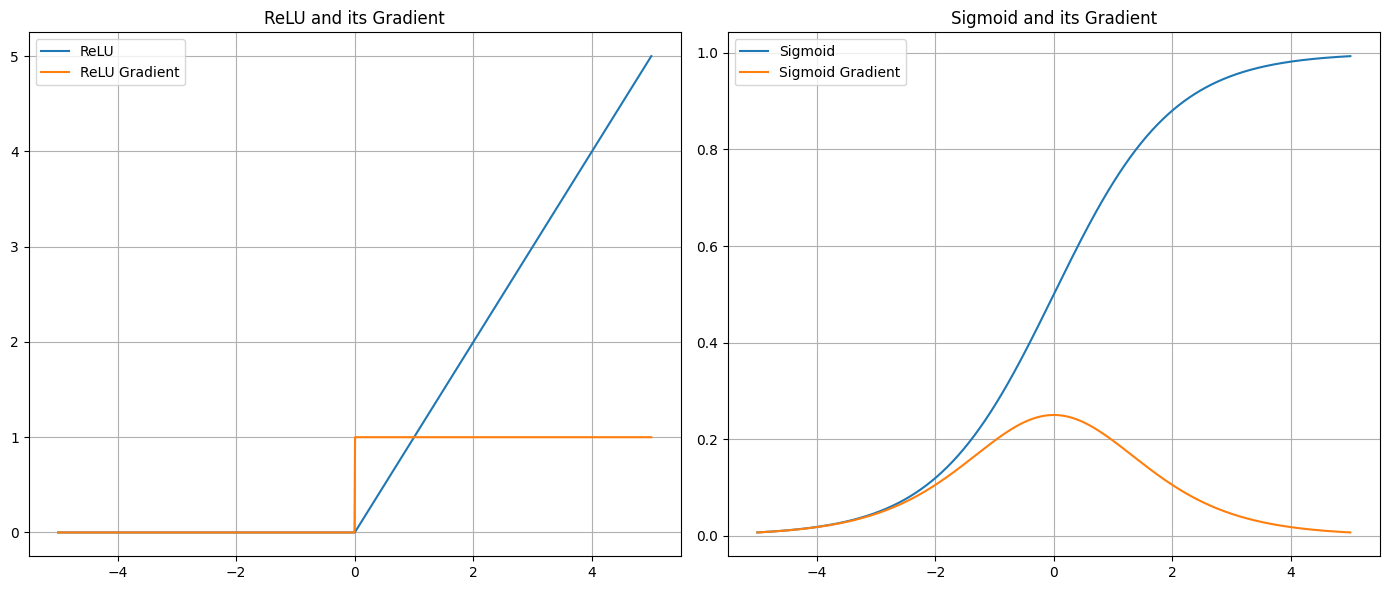

In [ ]:
visualize_gradients()

In [ ]:
def demonstrate_vanishing_gradient():
    # 심층 신경망에서의 기울기 소실 문제 시뮬레이션
    n_layers = 100  # 층의 수

    # 초기 그래디언트
    initial_gradient = torch.tensor(1.0)

    # ReLU와 Sigmoid의 그래디언트 전파 비교
    '''코드 작성'''
    #relu_gradients = [...]
    #sigmoid_gradients = [...]


    # 임의의 입력값 (양수는 ReLU가 그래디언트를 1로 유지)
    x_relu_positive = torch.tensor(0.5)
    # 임의의 입력값 (Sigmoid는 대부분의 경우 그래디언트가 0.25 미만)
    x_sigmoid = torch.tensor(0.0)  # Sigmoid의 그래디언트가 최대인 지점

    current_relu_grad = initial_gradient
    current_sigmoid_grad = initial_gradient

    for i in range(1, n_layers):
        # ReLU 그래디언트 전파
        '''코드 작성'''


        # Sigmoid 그래디언트 전파
        '''코드 작성'''


    # 시각화
    plt.figure(figsize=(10, 6))
    plt.semilogy(relu_gradients, label='ReLU Gradient (x > 0)')
    plt.semilogy(sigmoid_gradients, label='Sigmoid Gradient (x = 0)')
    plt.grid(True)
    plt.xlabel('Layer')
    plt.ylabel('Gradient Magnitude (log scale)')
    plt.title('Vanishing Gradient Problem Demonstration')
    plt.legend()
    plt.show()

    print(f"ReLU 그래디언트 (100층 후): {relu_gradients[-1]:.10f}")
    print(f"Sigmoid 그래디언트 (100층 후): {sigmoid_gradients[-1]:.10f}")

    # Sigmoid 추가 확인 - 극단적인 입력값에서
    x_extreme = torch.tensor(5.0)  # 매우 큰 양수
    extreme_sigmoid_grads = [initial_gradient.item()]
    current_grad = initial_gradient

    for i in range(1, n_layers):
        current_grad = CustomSigmoid.backward(x_extreme, current_grad)
        extreme_sigmoid_grads.append(current_grad.item())

    print(f"극단적인 입력(x=5)에서 Sigmoid 그래디언트 (100층 후): {extreme_sigmoid_grads[-1]:.10e}")


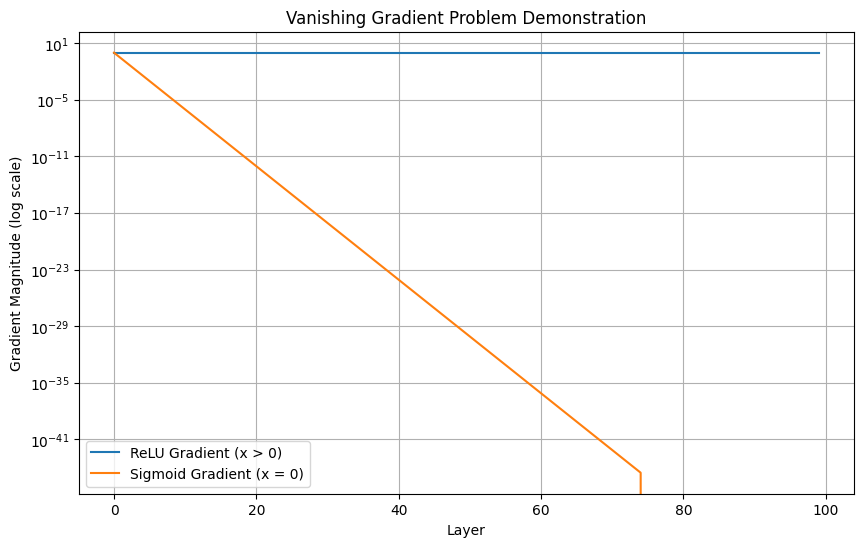

ReLU 그래디언트 (100층 후): 1.0000000000
Sigmoid 그래디언트 (100층 후): 0.0000000000
극단적인 입력(x=5)에서 Sigmoid 그래디언트 (100층 후): 0.0000000000e+00


In [ ]:
demonstrate_vanishing_gradient()